# Optimizers - When, Where and How to Tweak Them

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from exp.nb_08 import *

## Getting Imagenette Data From the DataBlock NB

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [4]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, 
        to_float_tensor]
bs = 128

img_list = ImageList.from_files(path, tfms=tfms)
split_data = SplitData.split_by_func(img_list, 
                                     partial(grandparent_splitter,
                                            valid_name='val'))

labels = label_by_func(split_data, parent_labeler, 
                       proc_y=CategoryProcessor())
data = labels.to_databunch(bs, c_in=3, c_out=10, 
                           num_workers=4)

In [5]:
# Create a model
nfs = [32, 64, 128, 256]

In [6]:
callbacks = [partial(AvgStatsCallback, accuracy),
             CudaCallback,
             partial(BatchTransformXCallback, norm_imagenette)]

In [7]:
# Baseline training with vanilla SGD
learn, run = get_learn_run(nfs, data, lr=0.4,
                          layer=conv_layer, cbs=callbacks)

In [8]:
run.fit(1, learn)

train: [1.7948843347370367, tensor(0.3808, device='cuda:0')]
valid: [1.6955538415605096, tensor(0.4425, device='cuda:0')]


## Refining the Optimizer

**`NOTES`**

- The base PyTorch optimizer in `torch.optim` is a dictionary which stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups.

- It contains `step` which updates our parameters with gradients and a method `zero_grad` to detach and zero the gradients of our parameters.

- We will build a more flexible equivalent from scratch. Here, the step function loops over all the parameters to execute the step using stepper functions, which we will provide when initializing the optimizer.

- This will end up giving us parameter groups / layer groups.

In [9]:
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        # Could be a generator
        self.param_groups = list(params)
        # Ensuring params is a list of lists of parameter tensors
        if not isinstance(self.param_groups[0], list):
            self.param_groups = [self.param_groups]
        # Creating a dictionary for individual param groups with
        # their own references
        self.hypers = [{**defaults} for p in self.param_groups]
        self.steppers = listify(steppers)
        
    def grad_params(self):
        return [(p, hyper) for pg, hyper in zip(self.param_groups, self.hypers)
                for p in pg if p.grad is not None]
    
    def zero_grad(self):
        for p, hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()
            
    def step(self): 
        # This step function doesn't do anything except carry out a
        # composition on items we pass on, which in turn carry out
        # their own operations. For e.g. one cycle annealing, 
        # discriminative LRs etc.
        for p, hyper in self.grad_params():
            compose(p, self.steppers, **hyper)

In [10]:
# To carry out SGD, via the stepper
def sgd_step(param, lr, **kwargs):
    param.data.add_(-lr, param.grad.data)
    return param

In [12]:
opt_func = partial(Optimizer, steppers=[sgd_step])

**`NOTES`**

- After changing the optimizer, we will need to adjust the callbacks which used the properties from the PyTorch optimizer.

- Hyper-parameters are in the list of dictionaries `opt.hypers`.

In [13]:
# Updating the Recorder, ParamScheduler and LR_Find classes
class Recorder(Callback):
    def begin_fit(self): self.lrs, self.losses = [], []
        
    def after_batch(self):
        if not self.in_train: 
            return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
        
    def plot_lr(self): 
        plt.plot(self.lrs)
        
    def plot_loss(self):
        plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        losses = [o.item() for o in self.losses]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])
        

class ParamScheduler(Callback):
    _order = 1
    
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, listify(sched_funcs)
    
    def begin_batch(self):
        if not self.in_train:
            return
        fs = self.sched_funcs
        if len(fs)==1: 
            fs = fs*len(self.opt.param_groups)
        pos = self.n_epochs / self.epochs
        for f, h in zip(fs, self.opt.hypers):
            h[self.pname] = f(pos)
                

class LR_Find(Callback):
    _order = 1
    def __init(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: 
            return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr) ** pos
        for pg in self.opt.hypers:
            pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss
        

In [18]:
# Checking to see if the param scheduler and the recorder are working properly
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

callbacks = [partial(AvgStatsCallback, accuracy),
             CudaCallback, Recorder, 
             partial(ParamScheduler, 'lr', sched)]

In [19]:
learn, run = get_learn_run(nfs, data, lr=0.4, layer=conv_layer,
                           cbs=callbacks, opt_func=opt_func)

In [20]:
%time run.fit(1, learn)

train: [1.797036505636815, tensor(0.3871, device='cuda:0')]
valid: [1.4009017963773884, tensor(0.5274, device='cuda:0')]
CPU times: user 8.11 s, sys: 388 ms, total: 8.49 s
Wall time: 9.5 s


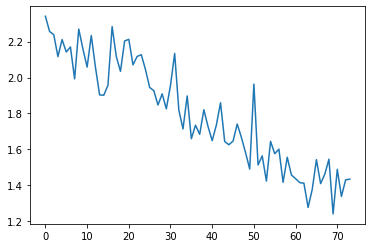

In [21]:
# Plotting loss
run.recorder.plot_loss()

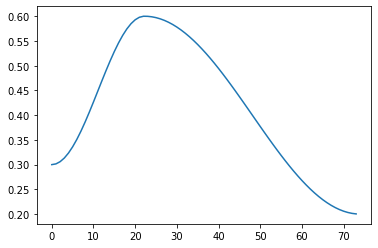

In [22]:
# Plotting LR
run.recorder.plot_lr()

## Implementing Weight Decay

**`NOTES`**

- In order to avoid over-fitting we will implement L2 regularization which is commonly known as weigth decay. Here we will be adding the sum of all the weights squared to our loss function. Doing this will ensure that the weights remain as small as possible when we compute the gradients.

- Limiting the weights from growing at a high rate is going to hinder the training of the model, but it yeilds a state where it generalizes better.

- Weight decay is a parameter that controls the sum of squares we add to our loss:
```python
loss_with_wd = loss + (wd/2) * (weights**2).sum()
```

- In practice it would be very inefficient to compute that big sum and add it to the loss. Alternatively, adding the big sum to our loss is the same as doing:
```python
weight.grad += wd * weight
```

- For every weight in our vanilla SGD is equivalent to updating the parameters with:
```python
wigh5t = weight - lr * (weight.grad + wd*weight)
```

- This results in the "decay" of each weight by a factor `lr * wd`. However, this only works for standard SGD, as we have seen with momentum, RMSProp and Adam, the update has some additional formulas around the gradient. In those cases the formula that comes from L2 regularization is:
```python
weight.grad += wd * weight
```
becomes different than weight decay
```python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

- It should be noted that most libraries use the first formula, but as pointed out in the paper [Decoupled Weight Regularization](https://arxiv.org/pdf/1711.05101.pdf), it is better to use the second one with the Adam optimizer.


In [24]:
def weight_decay(param, lr, wd, **kwargs):
    param.data.mul_(1 - lr*wd)
    return param

weight_decay._defaults = dict(wd=0.)

In [26]:
# L2 regularization adds wd*weight to the gradients
def l2_regularization(param, lr, wd, **kwargs):
    param.grad.data.add_(wd, param.data)
    return param

l2_regularization._defaults = dict(wd=0.)

In [27]:
# Allowing the steppers to add to our default hyper param values
# The helper function adds in 'dest' the key/values it finds while going
# through `os` and applying `f` when there was no `key` of the same name
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest:
                dest[k] = v
                
def get_defaults(d):
    return getattr(d, '_defaults', {})

 - The optimizer remains mostly the same as before, we only take the default values of the steppers when none are provided in the kwargs.

In [28]:
#export
class Optimizer():
    def __init__(self, params, steppers, **defaults):
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): 
            self.param_groups = [self.param_groups]
        self.hypers = [{**defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self):
        for p,hyper in self.grad_params(): 
            compose(p, self.steppers, **hyper)

In [29]:
sgd_opt = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [30]:
learn, run = get_learn_run(nfs, data, lr=0.4, layer=conv_layer,
                           cbs=callbacks, opt_func=sgd_opt)

In [31]:
# Before training let's check whether everythign works as intended
# If we dont't provide a value for 'wd', we will pull the corresponding
# default from 'weight_decay'
model = learn.model

In [32]:
opt = sgd_opt(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [36]:
# Now, when we provide a value, it overrides the default
opt = sgd_opt(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 0.0001)
test_eq(opt.hypers[0]['lr'], 0.1)

In [37]:
# Applying what we have built to our model
cbfs = [partial(AvgStatsCallback, accuracy), CudaCallback]

In [38]:
learn, run = get_learn_run(nfs, data, 0.3, layer=conv_layer,
                          cbs=callbacks, opt_func=partial(sgd_opt, wd=0.01))

In [39]:
%time run.fit(1, learn)

train: [1.7989498214568593, tensor(0.3740, device='cuda:0')]
valid: [2.636004428742038, tensor(0.2346, device='cuda:0')]
CPU times: user 8.11 s, sys: 386 ms, total: 8.5 s
Wall time: 9.5 s


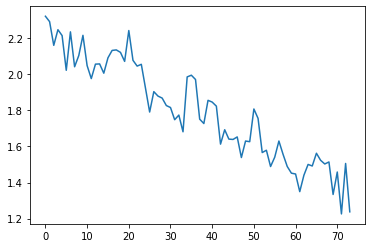

In [40]:
run.recorder.plot_loss()

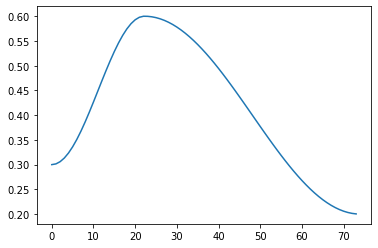

In [42]:
run.recorder.plot_lr()

**We've already improved the baseline!!**